<b><font color='darkred'>
SVM - Support Vector Machines
-----------------
➔ SVC & SVR mit Hyperparametersuche

- Subsampling (ts_len=None, subsample=10):
   - Kurve wird in der Gesamtlänge (= ms) nicht abgeschnitten
   - Auswahl der verwendeten Punkte über Schrittlänge (timestep 10)

In [28]:
import numpy as np
from sklearn import model_selection, svm
import helper

In [29]:
subsample =   10 # subsample austesten von versch. Längen 
ts_len    = None # Länge der Zeitreihe

SCALE = 2000

In [30]:
zugversuche, kurven, versuche_train, versuche_test = helper.read_data()

<b><font color='lightgreen'> Daten in 3-Dimensionen übertragen & nur Daten aller 10 Datenpunkte nutzen

In [31]:
subsample = helper.Subsample(subsample, ts_len)
subsample.fit() # Dummy

Subsample(subsample=10)

In [32]:
X_train = subsample.transform(versuche_train.key, kurven)
label_train = versuche_train.label.values
festigkeit_train = versuche_train.festigkeit.values
print(X_train.shape, label_train.shape)
print(X_train.max(axis=(0,1)))

X_test = subsample.transform(versuche_test.key, kurven)
label_test = versuche_test.label.values
festigkeit_test = versuche_test.festigkeit.values
print(X_test.shape)
print(X_test.max(axis=(0,1))) 

festigkeit_train = festigkeit_train/SCALE
festigkeit_test  = festigkeit_test/SCALE

(480, 10, 3) (480,)
[3600.84   623.066    4.08 ]
(120, 10, 3)
[3498.34   621.113    3.75 ]


<b><font color='lightgreen'> Skalieren Test- & Trainingsdaten  

In [33]:
tsMaxScale = helper.TsMaxScaler()
tsMaxScale.fit(X_train)
X_train_scaled = tsMaxScale.transform(X_train)
X_test_scaled  = tsMaxScale.transform(X_test)

<b><font color='lightgreen'> Darstellung der Schweisskurven X_train

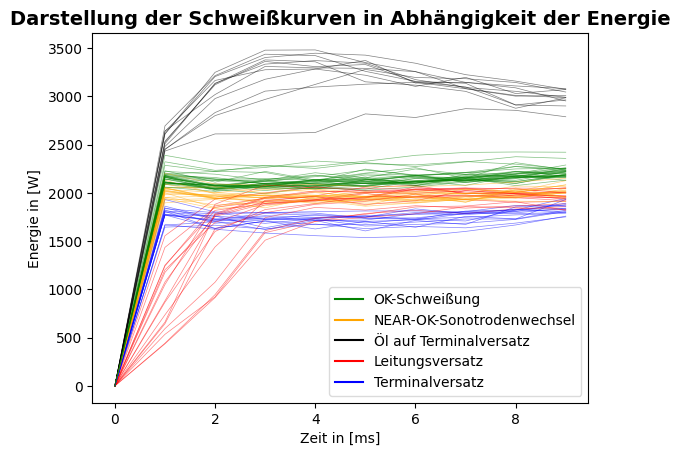

In [34]:
helper.plot_curves(X_train[:100,:,:], 0, label_train[:100], 'power')
# Komplette Kurve auf 10 Zeitpunkte in gleichem Abstand approximiert
# Insbesondere bei Leitungsverzug sieht man die Verzerrung der Kurven gegenüber den Originalzeitschritten

<b><font color='lightgreen'> Kontrollanzeige t-SNE

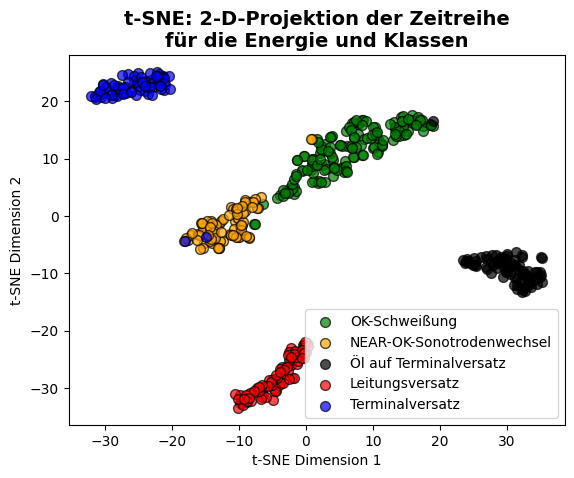

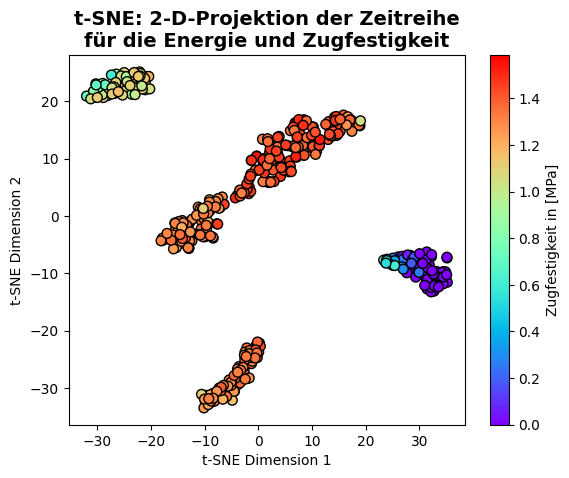

In [35]:
helper.plotTSNE(X_train_scaled, festigkeit_train, label_train, 'Energie', 'Klassen')
helper.plotTSNE(X_train_scaled, festigkeit_train, label_train, 'Energie', 'Zugfestigkeit')

<b><font color='darkred'> ____________________________________________________________________________________________________________________________________

<b><font color='darkred'>
SVM
-----------------
➔ kann nur 2-dimensionale Daten nutzen, daher Daten "flatten"     
➔ oder alternativ nur power verwenden (hier bessere Ergebnisse)     
  &emsp; <i> versuchsnr + zeitpunkt + power (daher die 0)

In [36]:
dims = X_train.shape
#X2_train = X_train_scaled.reshape(-1, dims[1]*dims[2])
#X2_test  = X_test_scaled.reshape(-1, dims[1]*dims[2])
X2_train = X_train_scaled[:,:,0]
X2_test  = X_test_scaled[:,:,0]

<b><font color='lightgreen'><h3> SVC - Support Vector Classification (Standardparameter)

In [37]:
modelSVC = svm.SVC(probability=True)
_ = modelSVC.fit(X2_train, label_train)

<b><font color='lightgreen'> Modellbewertung</b>

In [38]:
pred_train = modelSVC.predict(X2_train)
pred_test  = modelSVC.predict(X2_test)

helper.get_metric_table_class(label_train, pred_train, label_test, pred_test)

                        precision    recall  f1-score   support

                    ok      1.000     0.930     0.964        43
   near_ok_sonowechsel      0.826     1.000     0.905        19
            fehler_oel      1.000     1.000     1.000        17
fehler_leitungsversatz      1.000     1.000     1.000        17
  fehler_terminversatz      1.000     0.958     0.979        24

              accuracy                          0.967       120
             macro avg      0.965     0.978     0.969       120
          weighted avg      0.972     0.967     0.968       120



,Train,Test
Metric,,
Accuracy,0.977,0.967
Precision,0.978,0.972
Recall,0.977,0.967
F1-score,0.977,0.968


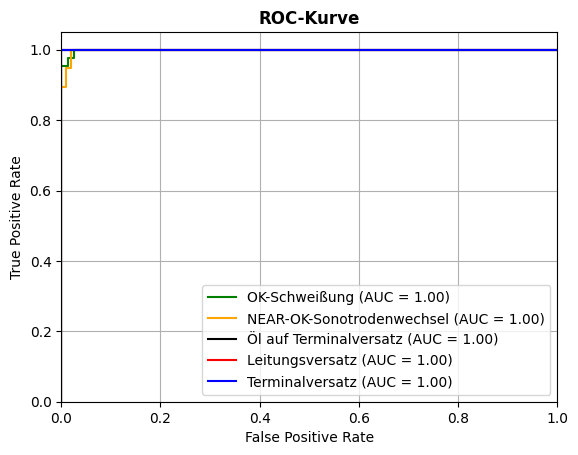

In [39]:
# Berechnung der Entscheidungsscores für die Testdaten
y_score = modelSVC.predict_proba(X2_test)
helper.plot_roc_curve(label_train, label_test, y_score)

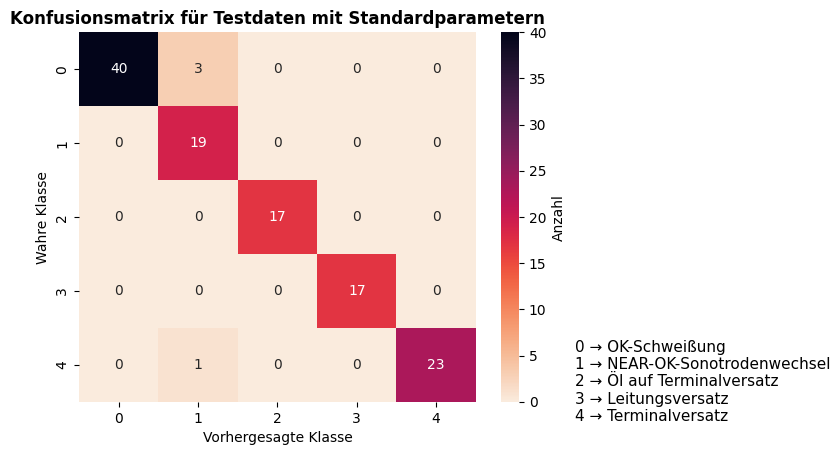

In [40]:
helper.plot_confusion(label_test, pred_test, 'Testdaten mit Standardparametern')

<b><font color='lightgreen'><h3> SVC - Support Vector Classification (Hyperparametersuche)

In [41]:
params = {
    'C': np.logspace(0, 4),
    'gamma': np.logspace(-5, 1),
    'kernel': ['rbf', 'linear']
}
random_search = model_selection.RandomizedSearchCV(
    svm.SVC(probability=True), 
    params, 
    n_iter=30,
)
random_search.fit(X2_train, label_train)
print("Beste Parameter:")
for param, value in random_search.best_params_.items():
    print(f"  {param:6}: {value:8.3f}" if isinstance(value, float) else f"  {param:6}: {value:>8}")

Beste Parameter:
  kernel:      rbf
  gamma :    0.339
  C     :  868.511


In [42]:
modelSVC_best = random_search.best_estimator_
_ = modelSVC_best.fit(X2_train, label_train)
modelSVC_best

SVC(C=868.511373751352, gamma=0.33932217718953295, probability=True)

<b><font color='lightgreen'> Modellbewertung</b>

In [43]:
pred_train = modelSVC_best.predict(X2_train)
pred_test  = modelSVC_best.predict(X2_test)

helper.get_metric_table_class(label_train, pred_train, label_test, pred_test)

                        precision    recall  f1-score   support

                    ok      1.000     0.953     0.976        43
   near_ok_sonowechsel      0.864     1.000     0.927        19
            fehler_oel      1.000     1.000     1.000        17
fehler_leitungsversatz      1.000     1.000     1.000        17
  fehler_terminversatz      1.000     0.958     0.979        24

              accuracy                          0.975       120
             macro avg      0.973     0.982     0.976       120
          weighted avg      0.978     0.975     0.976       120



,Train,Test
Metric,,
Accuracy,0.994,0.975
Precision,0.994,0.978
Recall,0.994,0.975
F1-score,0.994,0.976


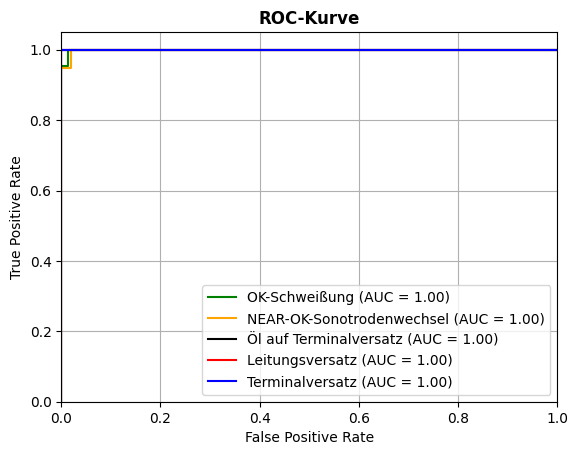

In [44]:
# Berechnung der Entscheidungsscores für die Testdaten
y_score = modelSVC_best.predict_proba(X2_test)
helper.plot_roc_curve(label_train, label_test, y_score)

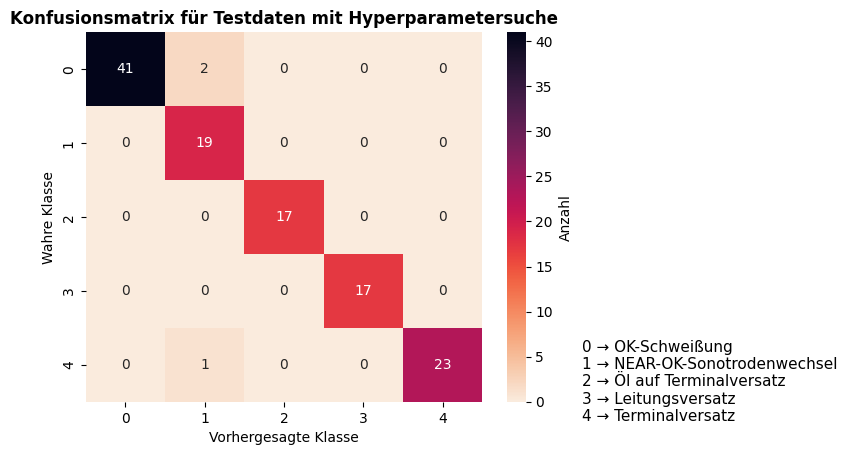

In [45]:
helper.plot_confusion(label_test, pred_test, 'Testdaten mit Hyperparametersuche')

<b><font color='lightgreen'><h3> SVR - Support Vector Regression (Standardparameter)

In [46]:
regr = svm.SVR()
regr.fit(X2_train, festigkeit_train)
print("Training abgeschlossen")

y_pred_train = regr.predict(X2_train)
y_pred_test = regr.predict(X2_test)

Training abgeschlossen


<b><font color='lightgreen'> Vorhersage Trainings- & Testdaten

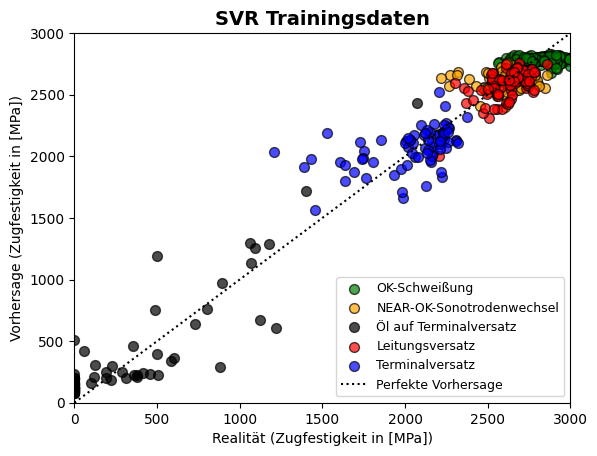

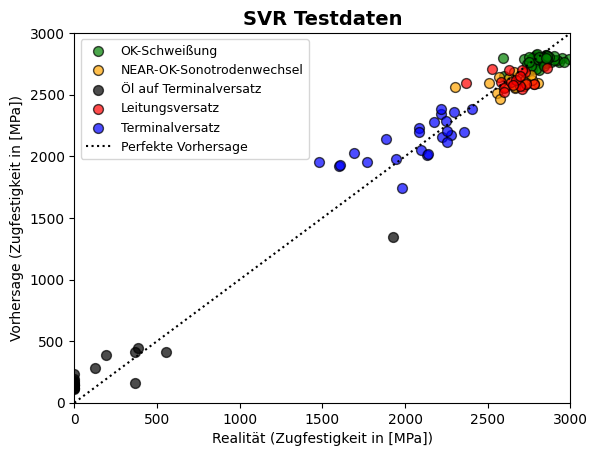

In [47]:
helper.plot_pred(y_pred_train, festigkeit_train, label_train, 'SVR Trainingsdaten', 'mit Linie', SCALE)
helper.plot_pred(y_pred_test, festigkeit_test, label_test, 'SVR Testdaten', 'mit Linie', SCALE)

<b><font color='lightgreen'> Modellbewertung</b>

In [48]:
helper.get_metric_table_regr(festigkeit_train, y_pred_train, festigkeit_test, y_pred_test, SCALE)

,Train,Test
Metric,,
MSE,25487.85,21401.39
RMSE,159.65,146.29
MAE,120.56,114.48
R²,0.97,0.97


<b><font color='lightgreen'><h3> SVR - Support Vector Regression (Hyperparameter) </b>

<b><font color='lightgreen'> Hyperparametersuche </b>
- <i> https://scikit-learn.org/1.5/modules/grid_search.html

In [49]:
params = {
    #'C': scipy.stats.expon(100),
    #'gamma': scipy.stats.expon(0.01),
    'C': np.logspace(0, 4),
    'gamma': np.logspace(-5, 1),
    'kernel': ['rbf', 'linear'],
}
estimator = model_selection.RandomizedSearchCV(
    svm.SVR(),  # Modell, für das die Hyperparameter optimiert werden
    params,     # Suchraum
    n_iter=30,  # zufällig 30 Kombinationen der Hyperparameter aus dem Suchraum testen
)
# für jede der 30 Hyperparameterkombinationen wird das Modell trainiert & die Güte mit Cross-Validation bewertet
estimator.fit(X2_train, festigkeit_train)
print('Best parameters:', estimator.best_params_)
estimator_best = estimator.best_estimator_

Best parameters: {'kernel': 'rbf', 'gamma': 4.291934260128778, 'C': 16.768329368110074}


In [50]:
y_pred_train = estimator_best.predict(X2_train)
y_pred_test = estimator_best.predict(X2_test)

<b><font color='lightgreen'> Vorhersage Trainings- & Testdaten

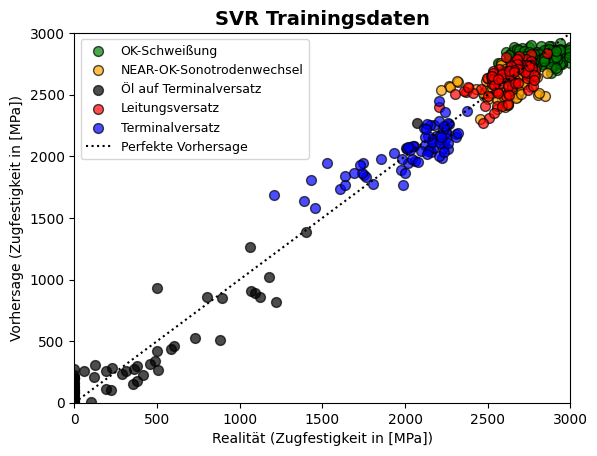

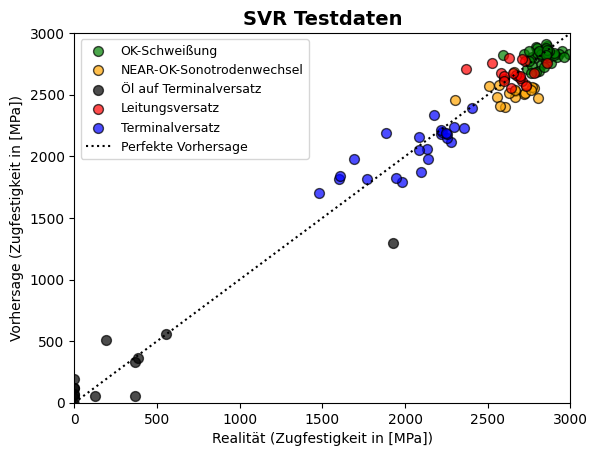

In [51]:
helper.plot_pred(y_pred_train, festigkeit_train, label_train, 'SVR Trainingsdaten', 'mit Linie', SCALE)
helper.plot_pred(y_pred_test, festigkeit_test, label_test, 'SVR Testdaten', 'mit Linie', SCALE)

<b><font color='lightgreen'> Modellbewertung</b>

In [52]:
helper.get_metric_table_regr(festigkeit_train, y_pred_train, festigkeit_test, y_pred_test, SCALE)

,Train,Test
Metric,,
MSE,17102.47,20363.14
RMSE,130.78,142.70
MAE,105.18,107.46
R²,0.98,0.97
